**Description**: Simulation experiment for [my answer on
stats.stackexchange.com](https://stats.stackexchange.com/a/614033/337906). This
experiment suggests that training on test set features (no labels) is not okay if the
features are not truly full rank and the sample size is too low.

**Estimated runtime**: 1 min.

**Package requirements**:
```
matplotlib==3.4.3
scikit-learn==0.24.2
tqdm==4.62.3
```

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Set simluation parameters

These are for generating data from a linear model, where features can be correlated with
each other.

In [2]:
NUM_TRIALS = 300

# sample sizes
NUM_TRAIN_OBS = 100  # obs to train linear regression on
NUM_TEST_OBS = (list(range(25, 200, 25)) +
                list(range(200, 500, 50)))  # also the # of obs to fit PCA  

# features
NUM_FEATURES = 20              # keep in mind the number of train and test obs
NUM_FEATURES_INFORMATIVE = 10  # must be <= NUM_FEATURES ofc
EFFECTIVE_RANK = 6             # < NUM_FEATURES implies PCA should help
NUM_PCA_COMPONENTS = int(0.6*EFFECTIVE_RANK)  # what do we often get in practice?

# seeds
RANDOM_STATE_GENERATE_DATA = 123
RANDOM_STATE_SPLIT_DATA = 42

# labels
NOISE_ST_DEV = 1.0

## Run simulations

In [3]:
def _split(X: np.ndarray,
           y: np.ndarray,
           num_test: int,
           num_train: int=NUM_TRAIN_OBS,
           random_state: int=None,
    ) -> tuple[np.ndarray, np.ndarray,
               np.ndarray, np.ndarray,
               np.ndarray, np.ndarray]:
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=num_train,
                                              random_state=random_state)
    random_state = None if random_state is None else random_state+1
    X_ex, X_te, y_ex, y_te = train_test_split(X_te, y_te, train_size=num_test,
                                              test_size=num_test,
                                              random_state=random_state)
    return (X_tr, X_ex, X_te,
            y_tr, y_ex, y_te)

In [4]:
def _simulation(X: np.ndarray,
                y: np.ndarray,
                num_test: int,
                num_trials: int=NUM_TRIALS,
                n_components: int=EFFECTIVE_RANK  # assume it's known for now
    ) -> tuple[np.ndarray, np.ndarray]:
    rmses_ex: list[float] = []
    rmses_te: list[float] = []

    for i in tqdm(range(num_trials)):
        X_tr, X_ex, X_te, y_tr, _, y_te = _split(X, y, num_test=num_test,
                                                 random_state=RANDOM_STATE_SPLIT_DATA+i)

        def rmse(X_for_fitting_pca) -> float:
            pca = PCA(n_components=n_components).fit(X_for_fitting_pca)
            X_tr_reduced = pca.transform(X_tr)
            model = LinearRegression().fit(X_tr_reduced, y_tr)
            # score the model on test
            X_te_reduced = pca.transform(X_te)
            y_te_pred = model.predict(X_te_reduced)
            return np.sqrt(np.mean((y_te_pred - y_te)**2))

        rmses_ex.append(rmse(X_ex))
        rmses_te.append(rmse(X_te))

    return np.array(rmses_ex), np.array(rmses_te)


def simulation():
    rmses_ex = []
    rmses_te = []
    for num_test in tqdm(NUM_TEST_OBS):
        X, y = make_regression(n_samples=NUM_TRAIN_OBS + num_test + num_test,
                               n_features=NUM_FEATURES,
                               n_informative=NUM_FEATURES_INFORMATIVE,
                               effective_rank=EFFECTIVE_RANK,
                               noise=NOISE_ST_DEV,
                               random_state=RANDOM_STATE_GENERATE_DATA)
        _rmses_ex, _rmses_te = _simulation(X, y, num_test)
        rmses_ex.append(_rmses_ex)
        rmses_te.append(_rmses_te)
    return np.array(rmses_ex), np.array(rmses_te)

In [5]:
rmses_ex, rmses_te = simulation()

100%|██████████| 13/13 [00:37<00:00,  2.90s/it]


In [6]:
paired_diffs: np.ndarray = rmses_ex - rmses_te
standard_errors = np.sqrt(np.var(paired_diffs, axis=1, ddof=1) / rmses_ex.shape[1])

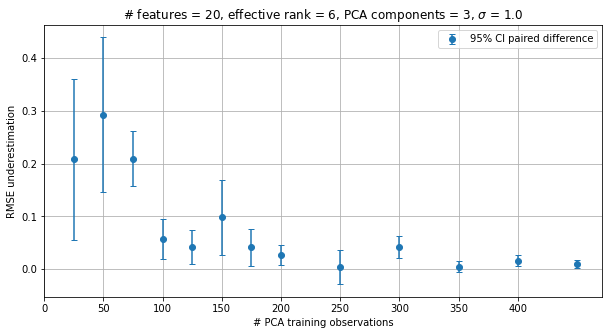

In [7]:
plt.figure(figsize=(10,5))
plt.errorbar(x=NUM_TEST_OBS,
             y=paired_diffs.mean(axis=1),
             yerr=1.96*standard_errors,
             fmt='o',
             capsize=3,
             label='95% CI paired difference')
plt.xlabel('# PCA training observations')
plt.ylabel('RMSE underestimation')
plt.title(f'# features = {NUM_FEATURES}, '
          f'effective rank = {EFFECTIVE_RANK}, '
          f'PCA components = {NUM_PCA_COMPONENTS}, '
          f'$\sigma$ = {NOISE_ST_DEV}')
plt.xticks(np.arange(0, max(NUM_TEST_OBS), step=50))
plt.grid()
plt.legend();